In [1]:
import sys
sys.path.append("/Users/sam/All-Program/App/ObjectDetection/")

import numpy as np
from MaskRCNN.config import config 

## Generate a config 

In [2]:
class ShapesConfig(config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    IMAGE_SHAPE = [128, 128, 3]

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
conf = ShapesConfig()
conf.display()


Configurations:
BATCH_NORM_DECAY                         0.9
BBOX_STD_DEV                             [ 0.1  0.1  0.2  0.2]
DETECTION_MIN_THRESHOLD                  0.7
DETECTION_NMS_THRESHOLD                  0.3
DETECTION_POST_NMS_INSTANCES             100
GPU_COUNT                                1
IMAGES_PER_GPU                           8
IMAGE_MAX_DIM                            128
IMAGE_MIN_DIM                            128
IMAGE_MIN_SCALE                          0
IMAGE_RESIZE_MODE                        square
IMAGE_SHAPE                              [128, 128, 3]
MEAN_PIXEL                               [ 123.7  116.8  103.9]
NAME                                     shapes
NUM_CLASSES                              4
POST_NMS_ROIS_INFERENCE                  1000
POST_NMS_ROIS_TRAINING                   2000
PRE_NMS_ROIS_INFERENCE                   6000
RESNET_STRIDES                           [4, 8, 16, 32, 64]
RPN_ANCHOR_RATIOS                        [0.5, 1, 2]
RPN_ANCHOR_S

## Generate Random Images, Squares traingle and circle.

In [15]:
from MaskRCNN.building_blocks import utils
import random

class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        print('load_shapes ................')
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        print('load_image ................')
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        print('image_reference ................')
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        print('load_mask ................')
        info = self.image_info[image_id]
        print ('info.... ', info)
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        print('draw_shape ................')
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
#         print('random_shape ................')
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
#         print('random_image ................')
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [16]:
config.IMAGE_SHAPE[0]

1024

In [17]:
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, conf.IMAGE_SHAPE[0], conf.IMAGE_SHAPE[1])
dataset_train.prepare()

load_shapes ................
prepare ...........


In [18]:
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, conf.IMAGE_SHAPE[0], conf.IMAGE_SHAPE[1])
dataset_val.prepare()

load_shapes ................
prepare ...........


In [19]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
image_ids

array([360,  43, 435,  52])

In [20]:
import math
import cv2
dataset_train.load_image(image_ids[0]).shape

load_image ................
draw_shape ................
draw_shape ................


(128, 128, 3)

In [23]:
print(dataset_train.load_mask(image_ids[0])[0].shape)
print(dataset_train.load_mask(image_ids[0])[1].shape)
#[0].shape

load_mask ................
info....  {'path': None, 'shapes': [('triangle', (33, 189, 69), (39, 86, 32)), ('triangle', (144, 135, 234), (42, 22, 31))], 'height': 128, 'id': 360, 'width': 128, 'source': 'shapes', 'bg_color': array([212,   2,  46])}
draw_shape ................
draw_shape ................
(128, 128, 2)
load_mask ................
info....  {'path': None, 'shapes': [('triangle', (33, 189, 69), (39, 86, 32)), ('triangle', (144, 135, 234), (42, 22, 31))], 'height': 128, 'id': 360, 'width': 128, 'source': 'shapes', 'bg_color': array([212,   2,  46])}
draw_shape ................
draw_shape ................
(2,)


In [9]:
dataset_train.load_mask(image_ids[0])[1]

load_mask ................
draw_shape ................


array([2], dtype=int32)

load_image ................
draw_shape ................
load_mask ................
draw_shape ................
(128, 128, 1)


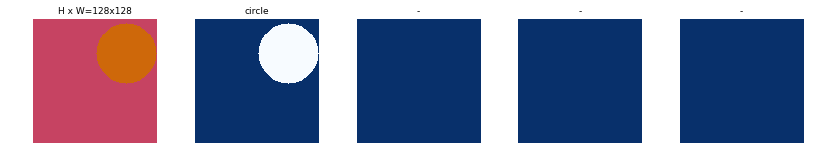

In [14]:
import math
import cv2
from MaskRCNN import visualize
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(mask.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    break

In [17]:
import random
import cv2
import math
import numpy as np
from MaskRCNN.building_blocks import utils


class Dataset():
    def __init__(self, num_images, height, width, num_classes):
        self.image_meta = {}
        self.num_classes = num_classes
        self.class_names = dict(square=0, triangle=1, circle=2)
        
        for i in range(0, num_images):
            self.image_meta[i] = self.build_images_meta(height, width)
    
    def draw_bg_image(self, height, width, bg_color):
        bg_ = np.array(bg_color).reshape([1, 1, 3])
        bg_image = np.ones([height, width, 3]) * np.array(bg_, dtype=np.uint8)
        return bg_image
    
    def draw_object_shape(self, image, object_, color, dims):
        ''' WHY THE WEIRDNESS IN FORMULA

        :param bg_image:
        :param object_info:
        :return:

        Important Note: When you look at the formulas, it might seem weird or rather oposite to what we are
        accustomed to use with numpy. This is because, we use OpenCV.

        Numpy          0,10 ____________ 10,10
                            |          |
                            |          |
                            |          |
                       0,0  |__________| 10,0

        OpenCV         0,0  ____________ 10,0
                            |          |
                            |          |
                            |          |
                       0,10 |__________| 10,10

        '''
        c_y, c_x, size = dims
        if object_ == 'square':
            cv2.rectangle(image, (c_x - size, c_y - size), (c_x + size, c_y + size), color, -1)
        elif object_ == 'circle':
            cv2.circle(img=image, center=(c_x, c_y), radius=size, color=color, thickness=-1)
        elif object_ == 'triangle':
            points = np.array([[(c_x, c_y - size),  # Top point
                                (c_x - size / math.sin(math.radians(60)), c_y + size),  # Bottom left
                                (c_x + size / math.sin(math.radians(60)), c_y + size),  # Bottom right
                                ]], dtype=np.int32)
            
            cv2.fillPoly(image, points, color)
        return image
    
    def gen_random_shapes(self, height, width):
        # select a random object (class)
        object_ = np.random.choice(['square', 'triangle', 'circle'])
        
        # Get random color for 3 channels
        color = tuple([random.randint(0, 255) for _ in range(3)])
        
        # Leave a buffer space (pad) of 20 pixels for the object_ to accomodate in the
        # background and collect a random center points (c_x, cy)
        buffer_space = 20
        c_y = np.random.randint(buffer_space, height - buffer_space - 1)
        c_x = np.random.randint(buffer_space, width - buffer_space - 1)
        
        # Get a Random size of the bounding box in which the object_ (tringle, square, cicle) is embedded
        size = np.random.randint(buffer_space, height // 4)
        # to account for both side towards the left form center to the right
        return object_, color, (c_y, c_x, size)
    
    def gen_random_image(self, height, width):
        # Pick a random 3 channel for the background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        
        # Pick randomly how many object_ to put in the background image frame
        num_objects = np.random.randint(1, self.num_classes)
        
        object_info = []
        bounding_boxes = []
        for _ in range(0, num_objects):
            object_, color, (c_y, c_x, size) = self.gen_random_shapes(height, width)
            object_info.append((object_, (color), (c_y, c_x, size)))
            bounding_boxes.append(
                    [c_y - size, c_x - size, c_y + size, c_x + size]
            )  # lower left and upper right coordinates
        bounding_boxes = np.array(bounding_boxes)
        # print(bounding_boxes)
        # Sometimes if we select two or more objects to be dispayed in the image we can have those images
        # to overlap completely. In such a case we should ensure that the non-max supression between the
        # objects are atleast 0.3 so that we dont mess out training labels.
        keep_idx = utils.non_max_supression(bounding_boxes, np.arange(num_objects), threshold=0.3)
        # print('object_info pre NMS ', object_info)
        object_info = [s for i, s in enumerate(object_info) if i in keep_idx]
        # print('keep_idx ', keep_idx)
        # print('objects post NMS ', object_info)
        return bg_color, object_info
    
    def build_images_meta(self, height, width):
        image_info = {}
        image_info['height'] = height
        image_info['width'] = width
        bg_color, object_info = self.gen_random_image(height, width)
        image_info['object_info'] = object_info
        image_info['bg_color'] = bg_color
        return image_info
    
    def get_object_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID. 

        Its the same shape as that of the image, however only the object part is colored white
        output_shape = [height, width, num_objects], where 

        """
        image_info = self.image_meta[image_id]
        object_info = image_info['object_info']
        object_cnt = len(object_info)
        mask = np.zeros([image_info['height'], image_info['width'], object_cnt], dtype=np.uint8)
        for i, (object_, _, dims) in enumerate(object_info):
            mask[:, :, i:i + 1] = self.draw_object_shape(mask[:, :, i:i + 1].copy(), object_, 1, dims)
        
        # Handle occlusions, when two objects intersect, we should ensure that the intersection mask is
        # given to only only object.
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        # print(occlusion)
    
        for i in range(object_cnt-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        return mask.astype(np.bool)

    def get_class_labels(self, image_id):
        object_info = self.image_meta[image_id]["object_info"]
        # Map class names to class IDs.
        class_ids = np.array([self.class_names[s[0]] for s in object_info])
        return class_ids.astype(np.int32)

    def get_images(self, image_id):
        image_info = self.image_meta[image_id]
        object_info = image_info['object_info']
        bg_color = image_info['bg_color']
        height = image_info['height']
        width = image_info['width']
        image = self.draw_bg_image(height, width, bg_color)
        # print(object_info)
        num_objects = len(object_info)
        
        for i in np.arange(num_objects):
            object_, color, dims = object_info[i]
            image = self.draw_object_shape(image, object_, color, dims)
        return image

## Visualize the Image, Objects and masks:

In [37]:
data = Dataset(num_images=5, height=128, width=128, num_classes=4)
image_ids = data.image_meta.keys()

images = []
masks = []
class_ids = []
for ids in image_ids:
    images.append(data.get_images(image_id=ids))
    masks.append(data.get_object_mask(image_id=ids))
    class_ids.append(data.get_class_labels(image_id=ids))

In [38]:
masks[0][:,:,0].shape

(128, 128)

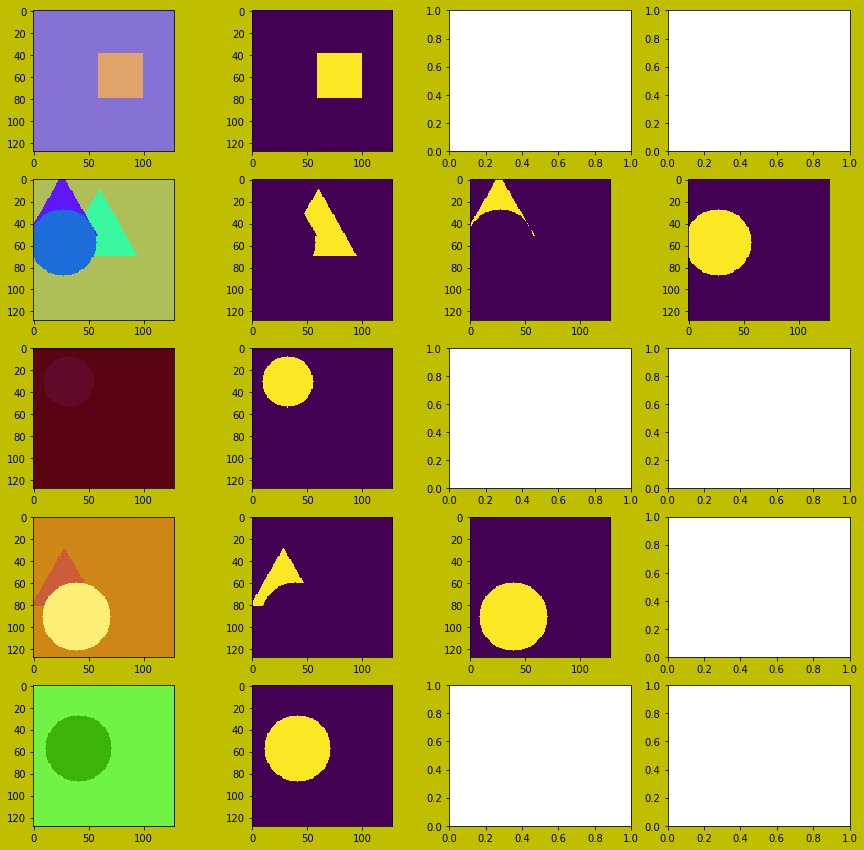

In [41]:
from MaskRCNN.visualize import Visualize
obj_viz = Visualize(rows=5, cols=4, figsize=(15,15))

for i in range(0,len(images)):
    obj_viz.vizualize_image(images[i])
    for j in range(0,3):
        if j < masks[i].shape[2]:
            obj_viz.vizualize_image(masks[i][:,:,j])
        else:
            obj_viz.num += 1
obj_viz.show()

In [40]:

obj_viz.vizualize_image(d)
obj_viz.vizualize_image()
obj_viz.show()

NameError: name 'd' is not defined

## TO DOS:

-- We have background color and class ids that have been selected to be in the image
-- We need to
    * generate masks for image
    * resize image  # Already wrote the function for this
    * resize masks, # Since we resize the image, we need to resize the mask
    * Do image augmentation (Horizontal flip), remember to flip the masks too. (Keep it simple: Dont do it for now)
    * make a data generation function, that can do stuff on the fly